In [2]:
import time
import random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

def draw_graph(graph):
    plt.figure(figsize=(3, 3))
    nx.draw(graph, node_size=3, node_color='red')
    plt.show()
    
def draw_ridgeplot(distributions, edge_probabilities):
    """Draws a ridgeplot of a distribution evolutions"""
    n_nodes = len(distributions[0])
    n_distributions = len(distributions)
    gs = GridSpec(n_distributions, 1, height_ratios=[1] * n_distributions, hspace=0.4)
    colors = ['#0000ff', '#3300cc', '#660099', '#990066', '#cc0033', '#ff0000']
    
    for i in range(n_distributions):
        x = np.arange(n_nodes)
        y = distributions[i]
        
        ax = plt.subplot(gs[i, 0])
        
        # Remove backgrounds and vertical labels
        ax.patch.set_alpha(0)
        ax.set_yticklabels([])
        ax.set_ylabel('')
        
        # Add horizontal label
        ax.text(-10,0,f"p = {edge_probabilities[i]:.3f}",fontsize=8,ha="center")
        
        # Fill curve
        ax.fill_between(x, y, 0, color=colors[i%len(colors)])
        
        # Remove borders
        spines = ["top","right","left","bottom"]
        for s in spines: ax.spines[s].set_visible(False)
            
        ax.plot(x, y, linestyle='None')
        
        # Add labels and title to the first subplot
        if i == 0:
            ax.set_title(f"Évolution de la distribution des degrés pour {n_nodes} nœuds")
    
        if i < n_distributions - 1: 
            # Remove xticks except for the last subplot
            ax.set_xticks([])
        else:
            # Add x label to the last subplot
            ax.set_xlabel("Degré")
        
    # Adjust layout
    gs.update(hspace= -0.5)
    
    plt.show()


## Question 1 - Graphes aléatoires
**Pouvez-vous trouver une probabilité de creation d'arête minimale `p_conn_min` où le graphe est connecté ?**

On note `p` la probabilité de création d'une arête.
Pour 100 nœuds, la connectivité varie de 0% à 100% lorsque `p` est compris entre 5% et 10%. 
Pour 1_000 nœuds, lorsque `p` se trouve entre 0.5% et 1%.
Pour 10_000 nœuds, lorsque `p` se trouve entre 0.05% et 0.1%.
La connectivité semble suivre une croissance en sorte de sigmoid généralisé (`1 / (1 + e^-x)`). Cependant, il est compliqué de déterminer sa formule.
On peut tout de même estimer une valeur pour `p_conn_min`, car on observe que la connectivité atteint 100% quand `p ~ 10 / n_nodes²`.

**Afficher un plot du pourcentage de nœuds dans le plus grand composant connexe. Y a-t-il un comportement particulier ?**

Pour 100 nœuds, la proportion varie de 0% à 100% lorsque `p` est compris entre 0% et 5%.
Pour 1_000 nœuds, lorsque `p` est compris entre 0% et 0.5%.
Pour 10_000 nœuds, lorsque `p` est compris entre 0% et 0.05%.
La proportion de nœuds dans le plus grand composant semble suivre une autre sigmoid avec une homothétie.

**Afficher l'évolution de la distribution des degrés. Peut-on prédire la distribution des degrés ?**

Pour afficher l'évolution de la distribution, il suffit de lancer la fonction `q1` avec `n_iterations=1`. On peut prédire la distribution des degrés, elle semble suivre une loi normale centrée sur `n_nodes * p_edge`. 
Par exemple, si on a 100 nœuds et `p_edge = 0.5`, le degré moyen sera de `100 * 0.5 = 50`.



                  Calcul de l'évolution des distributions pour 100 et 1000 noeuds                   


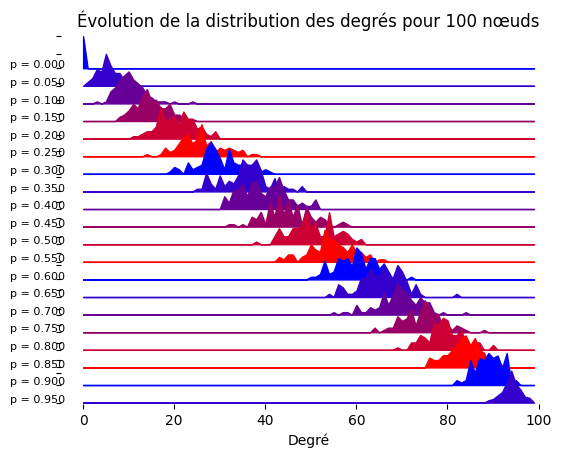

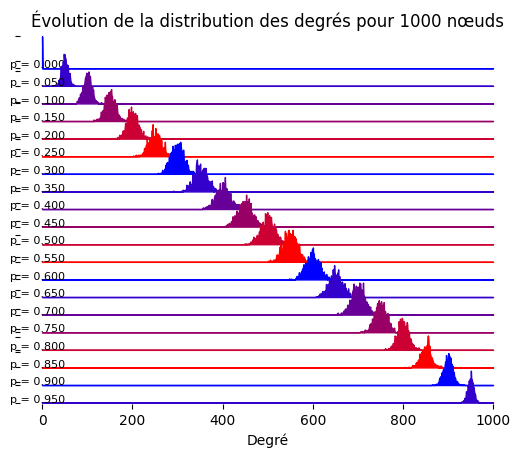

                 Calcul des stats en fonction de p pour 100, 1 000 et 10 000 noeuds                 
Connexion moyenne de 0.999% atteint à 8.00% pour 100 nœuds


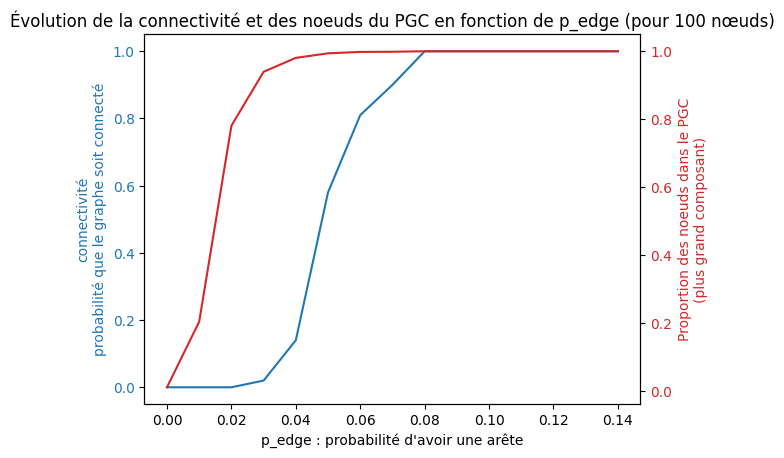

Connexion moyenne de 0.999% atteint à 1.20% pour 1000 nœuds


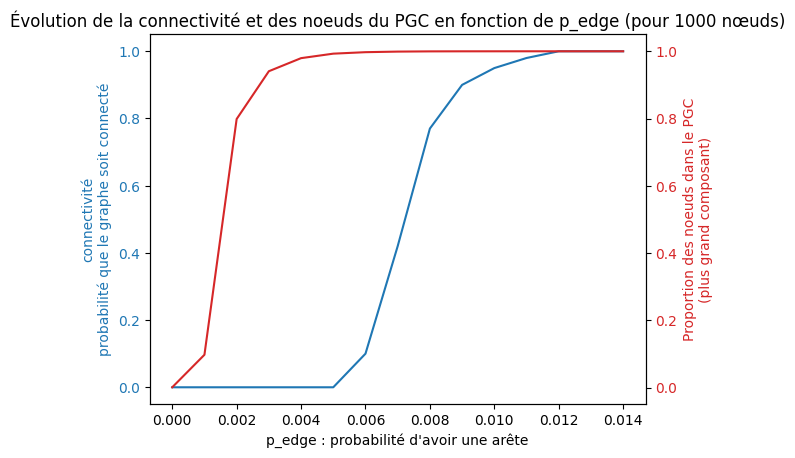

Connexion moyenne de 0.999% atteint à 0.12% pour 10000 nœuds


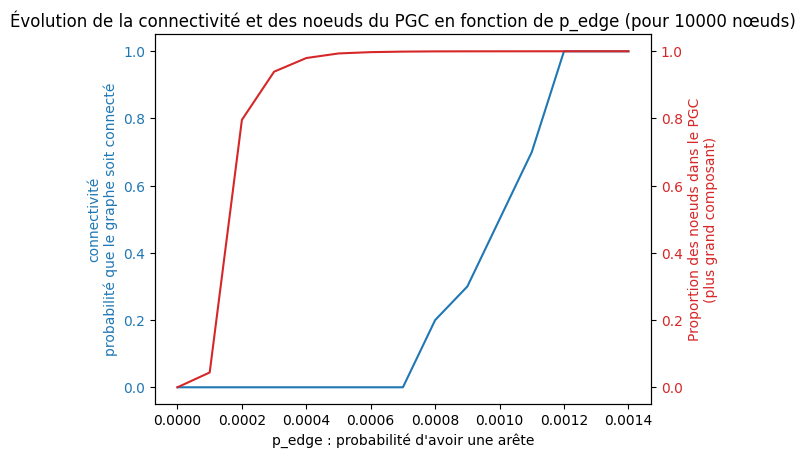

In [121]:
def q1(n_nodes, n_iterations, increment, prob_max, prob_min, connection_prob_target, draw_graph1=True):
    has_reached_target = False
    
    x = np.arange(prob_min, prob_max, increment)
    graph_connections = np.zeros(len(x))
    graph_largest_components = np.zeros(len(x))
    graph_degree_distributions = [None for _ in range(len(x))]

    # For each edge probability
    for i, edge_prob in enumerate(x):
        sum_connected, sum_largest_component = 0, 0
        
        # Calculate many graph connections
        for _ in range(0, n_iterations):
            graph = nx.fast_gnp_random_graph(n_nodes, edge_prob)
            
            if n_iterations == 1:
                distribution = nx.degree_histogram(graph)
                # Pad the degree distribution with 0s to have the same length for each graph
                graph_degree_distributions[i] = np.pad(distribution, (0, max(0, n_nodes - len(distribution))), mode='constant').tolist()
            
            sum_connected += nx.is_connected(graph)
            
            # Find the largest connected component
            largest_component = len(max(list(nx.connected_components(graph)), key=len))
            sum_largest_component += largest_component
            
        # Calculate average graph connection
        avg_connection = sum_connected / n_iterations
        
        # Calculate average size of largest component
        avg_largest_component = sum_largest_component / (n_iterations * n_nodes)
        
        # Check if the target has been reached
        if avg_connection >= connection_prob_target and not has_reached_target:
            if draw_graph1: print(f"Pour {n_nodes} nœuds : Connexion moyenne de {connection_prob_target}% atteinte à {edge_prob:.2%}")
            has_reached_target = True
        
        # Save the graph iterations stats
        graph_connections[i] = avg_connection
        graph_largest_components[i] = avg_largest_component
    
        # if (i/len(x)*100) % 10 == 0: print(f"{i/len(x):.0%}", end=" ")
    
    if n_iterations == 1: draw_ridgeplot(graph_degree_distributions, x)
    
    if not draw_graph1: return
    
    color = 'tab:blue'
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('p_edge : probabilité d\'avoir une arête')
    ax1.set_ylabel('connectivité\nprobabilité que le graphe soit connecté', color=color)
    ax1.set_title(f"Évolution de la connectivité et du PGC en fonction de p_edge (pour {n_nodes} nœuds)")
    ax1.plot(x, graph_connections, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Proportion des noeuds dans le PGC\n(plus grand composant)', color=color)
    ax2.plot(x, graph_largest_components, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()


print(f"Calcul de l'évolution des distributions pour 100 et 1000 noeuds".center(100))
q1(n_nodes=100, n_iterations=1, increment=.05, prob_max=1, prob_min=.0, connection_prob_target=.99, draw_graph1=False)
q1(n_nodes=1000, n_iterations=1, increment=.05, prob_max=1, prob_min=.0, connection_prob_target=.99, draw_graph1=False)

print(f"Calcul des stats en fonction de p pour 100, 1 000 et 10 000 noeuds".center(100))
q1(n_nodes=100, n_iterations=100, increment=.01, prob_min=.0, prob_max=.15, connection_prob_target=.999)
q1(n_nodes=1_000, n_iterations=100, increment=.001, prob_min=0, prob_max=.015,  connection_prob_target=.999)
q1(n_nodes=10_000, n_iterations=10, increment=.0001, prob_min=0, prob_max=.0015,  connection_prob_target=.999)


## Partie 2 - Simulation de jeu de graphes

### Faites une simulation de jeu de graphe simple (voir énoncé). Peut-on prédire la topologie du réseau ?  

La création d'arêtes se termine lorsque tous les timers sont écoulées.

Oui, on peut prédire la topologie du réseau. Cependant, l'énoncé n'étant pas assez clair, il y a plusieurs configurations possibles  
- Lorsqu'on crée une nouvelle arête, on peut ou pas mettre à jour la valeur du nœud cible → configuration réactive ou statique
- Lorsque plusieurs nœuds ont un timer à 0, on peut ajouter les arêtes successivement ou simultanément → configuration successive ou simultanée

On a donc 4 configurations possibles
Remarque : Dans la grande majorité des cas, les réseaux seront cycliques.
- successive et réactive : ressemble à un réseau avec clusters, c'est-à-dire que certains nœuds ont beaucoup plus de voisins que d'autres.
- successive et statique : ressemble à un réseau en chaine, c'est-à-dire que chaque nœud à deux voisins (le premier nœud est le seul à n'en n'avoir qu'un).
- simultanée et réactive : ressemble à la 1ʳᵉ configuration.
- simultanée et statique : ressemble à un réseau en chaine, mais avec de petite branche.


__Remarque__ : Les tests suivants ont été fait sur 300 nœuds au lieu de 10_000, et les stats sur une moyenne de 100 itérations, pour épargner du temps de calcul.  

| configurations | réactive                                   | statique                                     |
|----------------|--------------------------------------------|----------------------------------------------|
| successive     | 35% connectés, ~3 taille moyenne de chemin | 39% connectés, ~135 taille moyenne de chemin |
| simultanée     | 32% connected, ~3 taille moyenne de chemin | 39% connectés, ~84 taille moyenne de chemin  |

On remarque que les configurations réactive sont les meilleures, avec ~35% de graphes connectés et une longueur moyenne de chemin de 3.

### Rendez le modèle plus réaliste (voir énoncé). Comment changera la topologie ? Change-t-elle entre chaque itération ? Quel est la distribution des valeurs ? Afficher quelques graphes.

On rend le modèle plus réaliste en introduisant la divergence. Avec une divergence de 0.5, quand on veut la valeur de son voisin, on obtient entre 50% et 150% de la véritable valeur.  
La première chose que l'on observe, c'est que toutes les configurations obtiennent la même topologie (celle de la chaine avec des petites branches).

| configurations | réactive                                    | statique                                    |
|----------------|---------------------------------------------|---------------------------------------------|
| successive     | 39% connectés, ~22 taille moyenne de chemin | 37% connectés ~30 taille moyenne de chemin  |
| simultanée     | 38% connectés, ~20 taille moyenne de chemin | 38% connectés, ~29 taille moyenne de chemin |

La distribution des valeurs semble uniforme (entièrement aléatoire), peu importe la configuration (voir graphiques). 

                        Configuration : successive réactive sans divergence                         


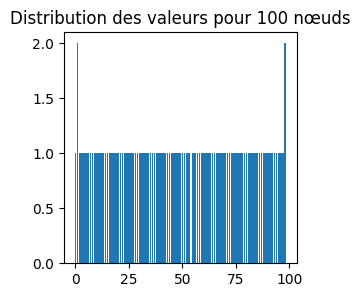

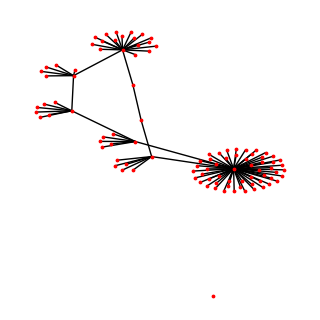

                        Calcul des stats sur 100 itérations sans divergence                         

Graphes connectés: 37%
Nombre de cycles moyens: 0.96
Longueur moyenne des graphes connectés : 2.81
                        Configuration : successive réactive avec divergence                         


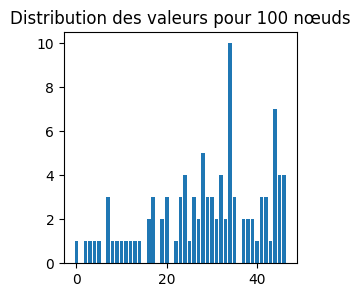

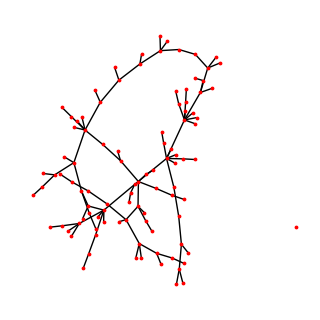

                     Calcul des stats sur 100 itérations avec divergence = 0.5                      

Graphes connectés: 42%
Nombre de cycles moyens: 0.98
Longueur moyenne des graphes connectés : 17.13
                        Configuration : successive statique sans divergence                         


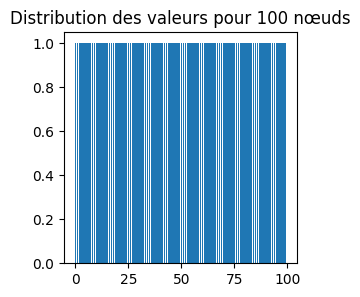

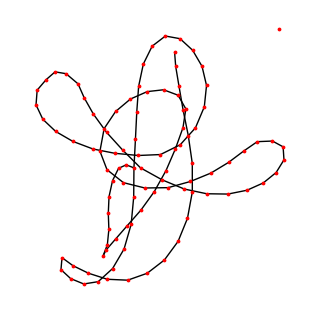

                        Calcul des stats sur 100 itérations sans divergence                         

Graphes connectés: 37%
Nombre de cycles moyens: 1.00
Longueur moyenne des graphes connectés : 82.41
                        Configuration : successive statique avec divergence                         


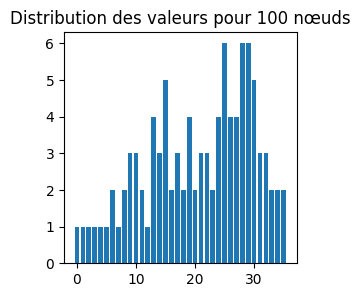

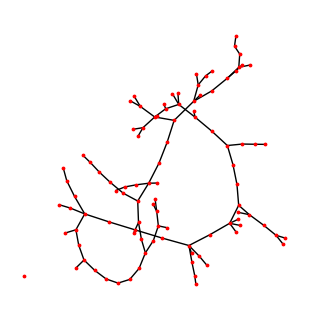

                     Calcul des stats sur 100 itérations avec divergence = 0.5                      

Graphes connectés: 36%
Nombre de cycles moyens: 1.00
Longueur moyenne des graphes connectés : 22.90
                         Configuration : simultané réactive sans divergence                         


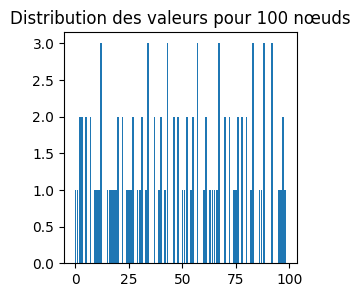

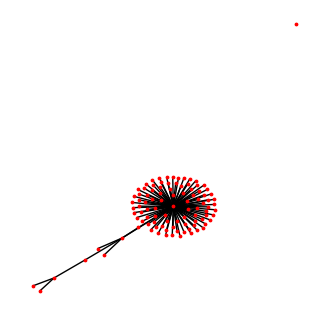

                        Calcul des stats sur 100 itérations sans divergence                         

Graphes connectés: 38%
Nombre de cycles moyens: 0.96
Longueur moyenne des graphes connectés : 2.81
                         Configuration : simultané réactive avec divergence                         


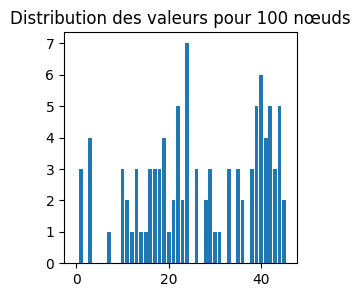

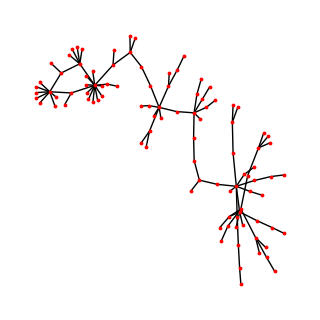

                     Calcul des stats sur 100 itérations avec divergence = 0.5                      

Graphes connectés: 38%
Nombre de cycles moyens: 0.99
Longueur moyenne des graphes connectés : 15.20
                         Configuration : simultané statique sans divergence                         


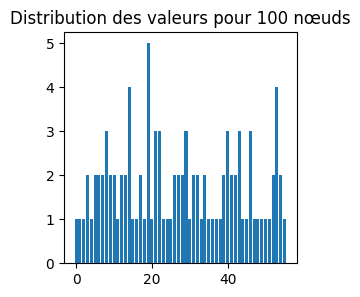

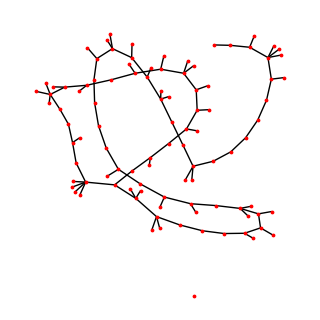

                        Calcul des stats sur 100 itérations sans divergence                         

Graphes connectés: 34%
Nombre de cycles moyens: 1.00
Longueur moyenne des graphes connectés : 51.51
                         Configuration : simultané statique avec divergence                         


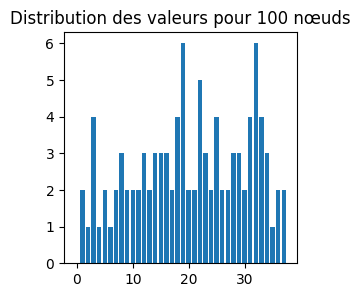

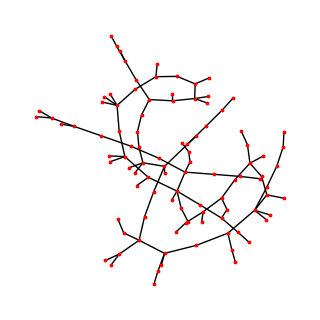

                     Calcul des stats sur 100 itérations avec divergence = 0.5                      

Graphes connectés: 25%
Nombre de cycles moyens: 1.00
Longueur moyenne des graphes connectés : 21.93


In [119]:
def graph_is_done(graph):
    """Check if the graph has a node with timer > 0"""
    for node in graph.nodes:
        if graph.nodes[node]['timer'] > 0: return False
    return True

def get_infos(graph, i, divergence):
    """Get the neighbors, the other nodes and the best node to connect to"""
    # Get the neighbors of the node
    neighbors = graph.neighbors(i)
    
    # Get all nodes except the specified node and its direct neighbors
    others = set(graph.nodes) - set([i] + list(neighbors))
    
    # If there are no other nodes, stop
    # This should never happen
    if not others:
        draw_graph(graph)
        print("No other nodes")
        raise Exception("No other nodes")
        
    # Get other node with the highest value, with a random factor
    best_node = sorted(
        others,
        key=lambda x: graph.nodes[x]['value'] * random.uniform(1-divergence, 1+divergence),
        reverse=True
    )[0]
    return neighbors, others, best_node
    
def successive_edge_addition(graph, reactive, divergence):
    """Decrements each timer and adds edge successively"""
    for i, node in graph.nodes(data=True):
        # Skip if timer is 0 or lower, TODO : Regarder ce qui se passe en remplaçant <= par <
        if node['timer'] <= 0: continue
        
        # Decrement timer
        node['timer'] -= 1
        
        # Skip if timer is not 0
        if node['timer'] > 0: continue
        
        try:
            neighbors, others, best_node = get_infos(graph, i, divergence)
        except:
            break
    
        # Add new edge to the node with the highest value
        graph.add_edge(i, best_node)
        graph.nodes[i]['value'] = graph.nodes[best_node]['value'] + 1
        
        # Update the value of the target node if needed
        if reactive: graph.nodes[best_node]['value'] += 1
        
    return graph

def simultaneous_edge_addition(graph, reactive, divergence):
    """Decrements each timer and adds edge simultaneously"""
    for node in graph.nodes: graph.nodes[node]['timer'] -= 1
    
    # List of nodes (only ids) to update (where the time is 0)
    nodes_to_update = set(node for node in graph.nodes if graph.nodes[node]['timer'] == 0)
    # Future graph
    next_graph = graph.copy()
    
    
    # Update each node independently
    for i in nodes_to_update:
        
        try:
            neighbors, others, best_node = get_infos(graph, i, divergence)
        except:
            break
        
        # Update next graph
        next_graph.add_edge(i, best_node)
        next_graph.nodes[i]['value'] = graph.nodes[best_node]['value'] + 1
        if reactive: next_graph.nodes[best_node]['value'] += 1
        
    return next_graph
    
def perform(n_nodes, successive, reactive, divergence):
    """Performs the simulation game of the graph"""
    # Creating empty graph
    graph = nx.empty_graph(n_nodes,create_using=nx.Graph())

    # Adding n_nodes nodes, each node has a random timer
    for i in range(n_nodes):
        graph.add_node(i, timer=np.random.randint(0, n_nodes), value=0)
    
    # Performing node addition until all nodes have a timer of 0
    while not graph_is_done(graph):
        if successive:
            graph = successive_edge_addition(graph, reactive, divergence)
        else:
            graph = simultaneous_edge_addition(graph, reactive, divergence)
    
    return graph
        
def q2(n_iterations, n_nodes, successive=False, reactive=False, draw=False, divergence=0):
    sum_shortest_paths = 0
    nb_connected_graphs = 0
    sum_cycles = 0
    
    for i in range(n_iterations):
        graph = perform(n_nodes, successive, reactive, divergence)
        
        is_connected = nx.is_connected(graph)
        
        # Value distribution
        if n_iterations == 1:
            values = [graph.nodes[node]['value'] for node in graph.nodes]
            distribution = np.bincount(values)
            plt.figure(figsize=(3, 3))
            plt.title(f"Distribution des valeurs pour {n_nodes} nœuds")
            plt.bar(range(len(distribution)), distribution)
            plt.show()
            
        # Nombre de cycles
        cycles = nx.algorithms.cycles.cycle_basis(graph)
        sum_cycles += len(cycles)
        
        # print("Connected" if is_connected else "Not connected")
        # print("Cyclic" if len(cycles) else "Not cyclic")
        if is_connected:
            nb_connected_graphs += 1
            sum_shortest_paths += nx.average_shortest_path_length(graph)
            # print(f"Average shortest path length : {nx.average_shortest_path_length(graph)}")
        
        if draw: 
            draw_graph(graph)
            time.sleep(1)
    
    # Don't calculate the average if there is only one iteration
    if n_iterations == 1: return
    

    # Calcul connectivité moyenne
    print(f"\nGraphes connectés: {nb_connected_graphs/n_iterations:.0%}")
    # Calcul nombre de cycles moyens
    print(f"Nombre de cycles moyens: {sum_cycles/n_iterations:.2f}")
    # Calcul longueur moyenne des graphes connectés
    print(f"Longueur moyenne des graphes connectés : {sum_shortest_paths/nb_connected_graphs:.2f}")

for successive, reactive in [(True, True), (True, False), (False, True), (False, False)]:
    print(f"Configuration : {'successive' if successive else 'simultané'} {'réactive' if reactive else 'statique'} sans divergence".center(100))
    q2(n_iterations=1, n_nodes=100, successive=successive, reactive=reactive, draw=True)
    print(f"Calcul des stats sur 100 itérations sans divergence".center(100))
    q2(n_iterations=100, n_nodes=300, successive=successive, reactive=reactive)
    print(f"Configuration : {'successive' if successive else 'simultané'} {'réactive' if reactive else 'statique'} avec divergence".center(100))
    q2(n_iterations=1, n_nodes=100, successive=successive, reactive=reactive, draw=True, divergence=0.5)
    print(f"Calcul des stats sur 100 itérations avec divergence = 0.5".center(100))
    q2(n_iterations=100, n_nodes=300, successive=successive, reactive=reactive, divergence=0.5)


## Partie 3 - Simulation avancée

### Ajoutez la possibilité pour un nœud de perdre ou créer un nouveau un lien au hasard (voir énoncé). Tester si cette méthode peut créer un réseau connecté stable, c.-à-d. que le pourcentage de nœuds connectés reste casi-constant à partir d'un moment.

Pour faire cela, on rajoute un paramètre `chaos` à la fonction perform. `chaos` est la probabilité que les nœuds aient un mauvais comportement.
__Remarque :__ Si le nœud se comporte mal, il peut supprimer OU ajouter une arête, mais pas les deux en même temps.
On a aussi besoin d'ajouter les propriétés `good_behavior` (nombre de bons comportements), `bad_behavior` (nombre de mauvais comportements), et `karma` afin de pouvoir calculer le karma de chaque nœud.

Pour cette partie, on utilisera la **configuration successive réactive**.
Voici la nouvelle formule de tri pour savoir à quel nœud cible un nœud source va se connecter : `score = value * random.uniform(1-divergence, 1+divergence) * (1 - karma)`
Ici, on a fixé la divergence à 0.5, mais on pourrait aussi la faire varier.
D'après nos tests, plus le chaos augmente, plus le graphe devient rapidement connecté, cependant il n'est jamais connecté de manière stable. Le meilleur comportement est lorsque `chaos = 100%`. (voir graphiques)

### Montrez quelques analyses sur la distribution des valeurs, du karma, etc.

On fait les mesures pour 500 nœuds et une divergence nulle, en faisant varier le chaos :
- La distribution des valeurs uniformément répartie entre 0 et 200, elle est donc entièrement aléatoire.
- Soit X la variable "nombre de mauvais comportements", on remarque que X suit une loi binomiale de paramètres (n=`n_nodes`, p=`chaos`).
- Réciproquement, on remarque que la variable "nombre de bons comportements" suit une loi binomiale de paramètres (n=`n_nodes`, p=`1-chaos`).
- Le karma est donc la variable Z = X / (X + Y). Il semble suivre la loi normale centrée sur `chaos`.  

Pour résumer, le chaos permet au graphe de se connecter bien plus rapidement. De plus, on n'augmente pas forcément le nombre d'arêtes par rapport au jeu de la partie 2, car la probabilité de supprimer une arête et la même que d'en ajouter une. Il s'agit donc s'un système plus performant pour un plus grand coût de calcul.


                                           Chaos : 0%                                           


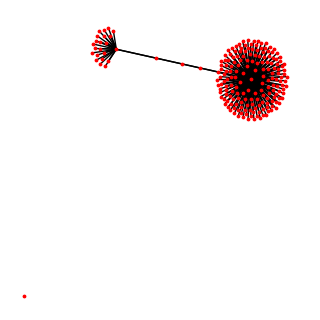

KARMA n'a qu'une valeur 0.0
BAD_BEHAVIOR n'a qu'une valeur 0
GOOD_BEHAVIOR n'a qu'une valeur 195


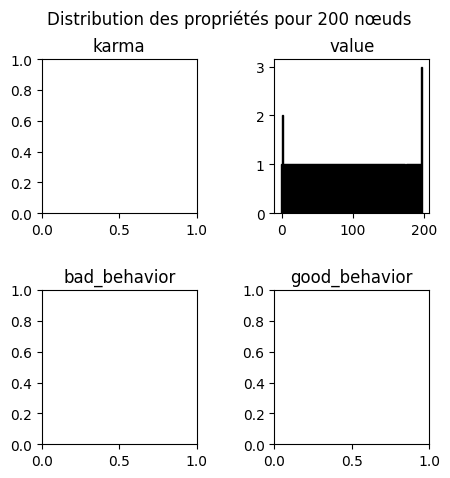

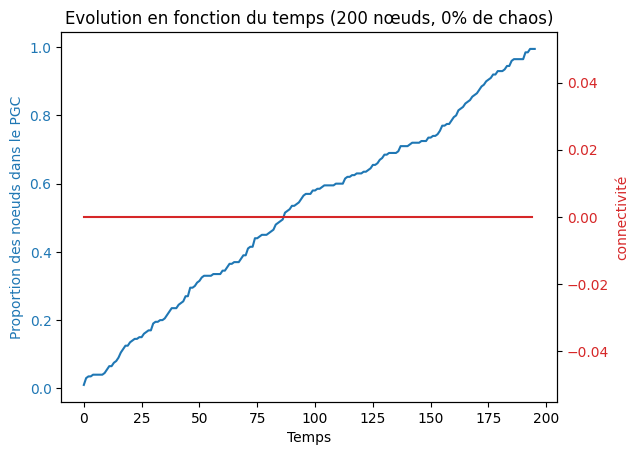

                                           Chaos : 1%                                           


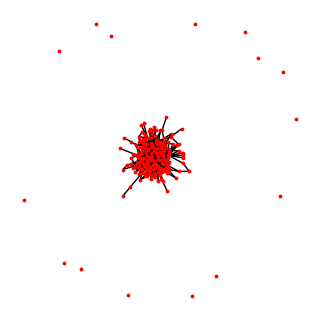

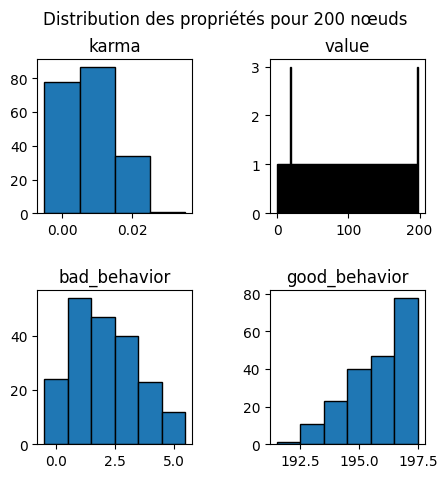

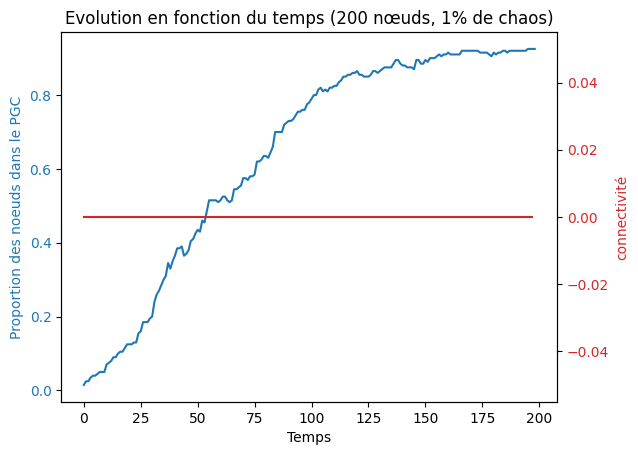

                                          Chaos : 10%                                           


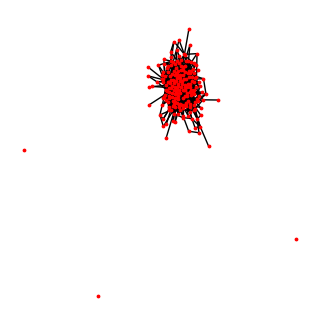

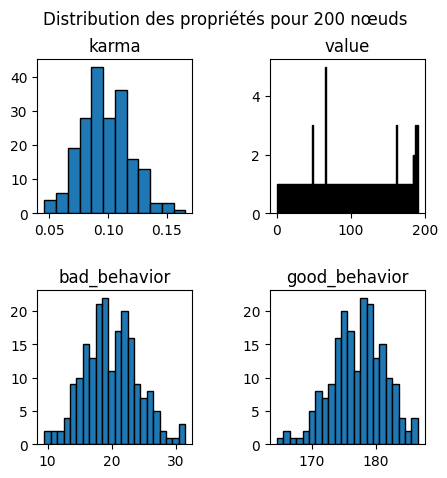

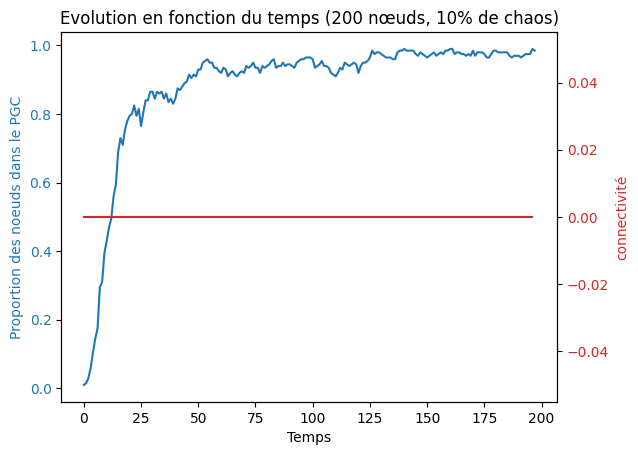

                                          Chaos : 20%                                           


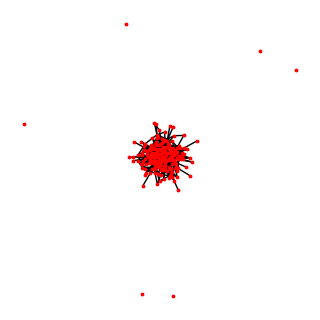

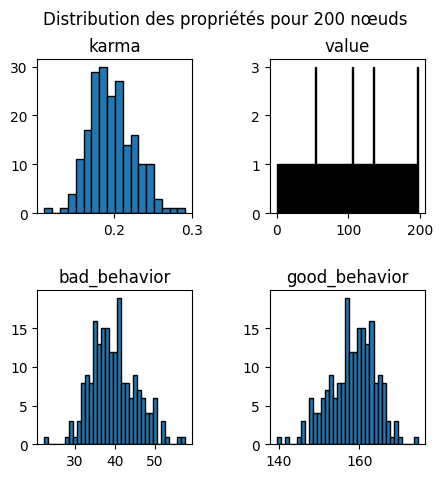

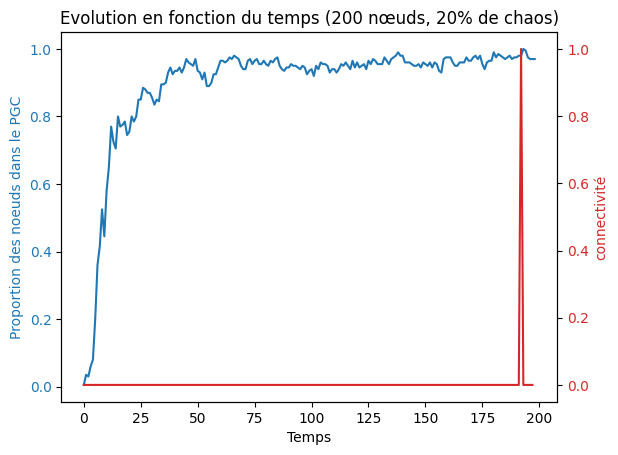

                                          Chaos : 50%                                           


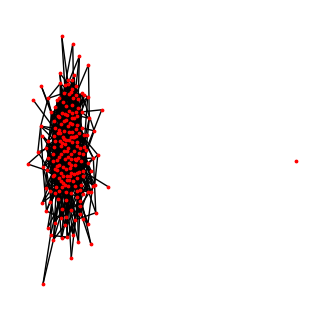

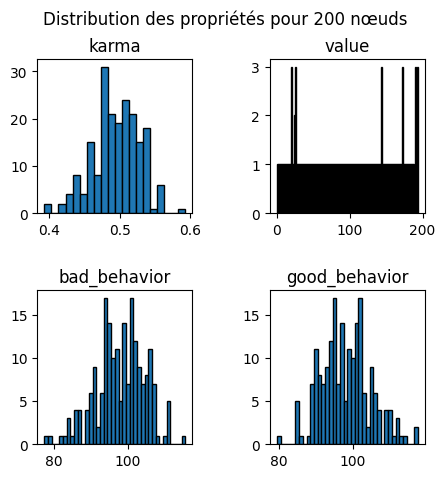

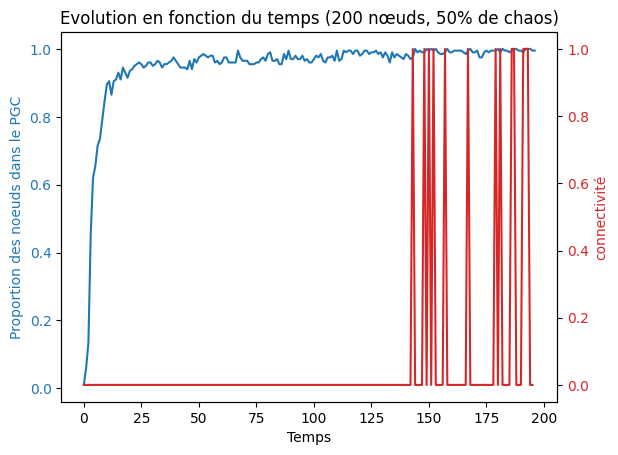

                                          Chaos : 60%                                           


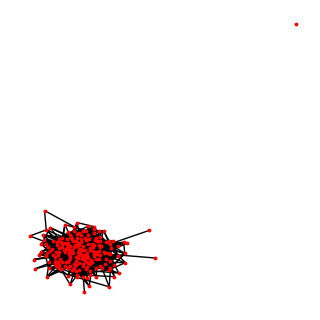

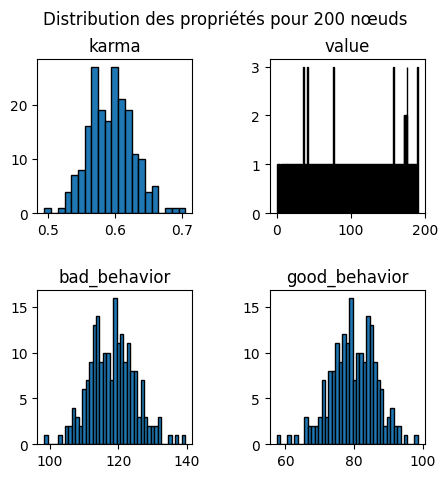

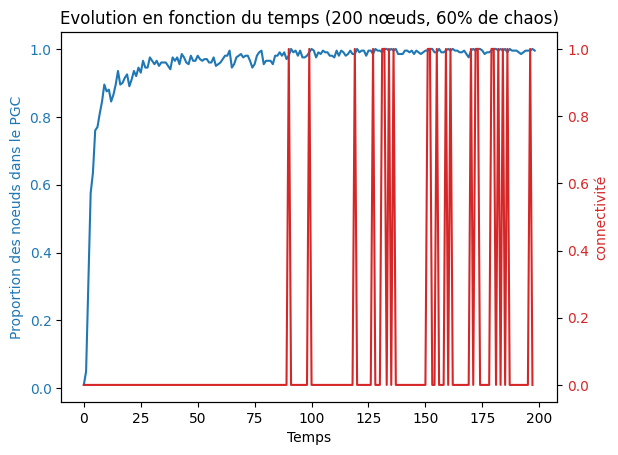

                                          Chaos : 80%                                           


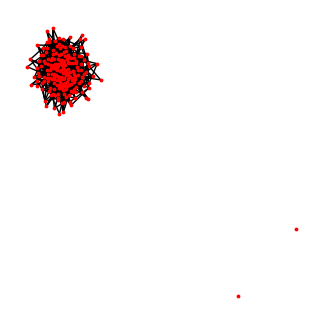

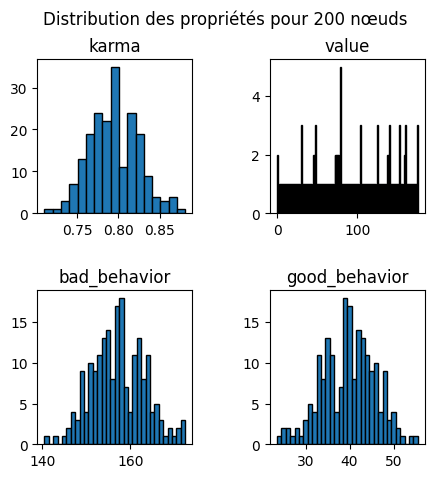

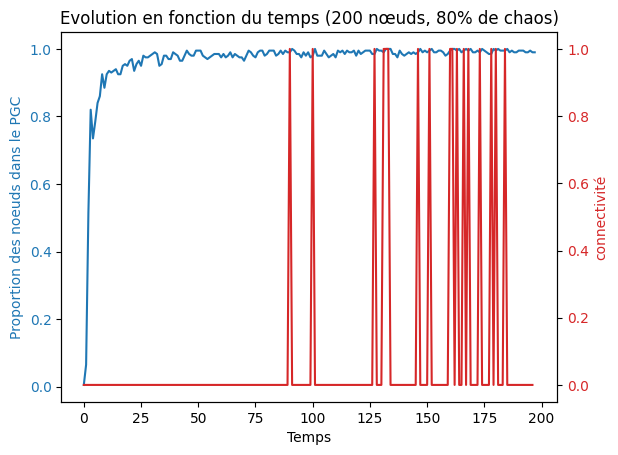

                                          Chaos : 100%                                          


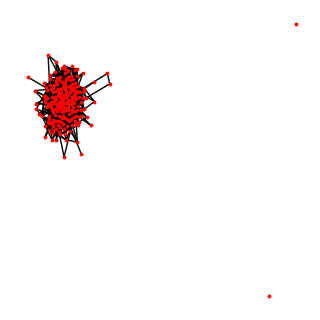

BAD_BEHAVIOR n'a qu'une valeur 198
GOOD_BEHAVIOR n'a qu'une valeur 0


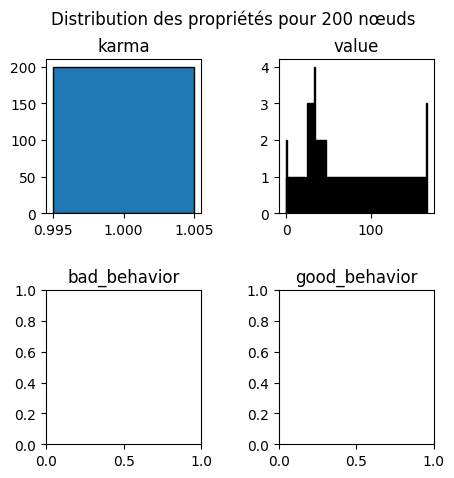

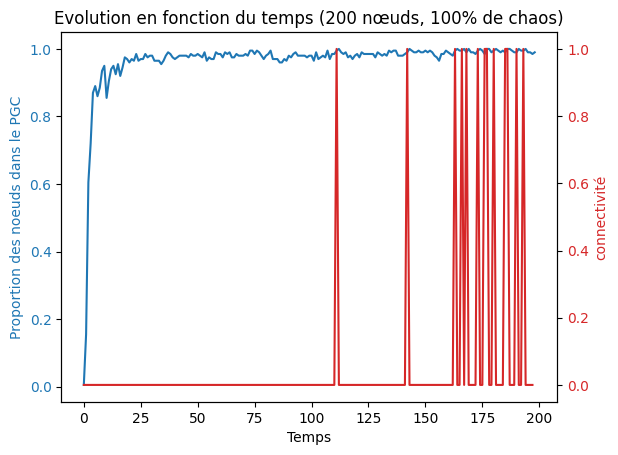

In [113]:
def get_infos_v2(graph, i, divergence):
    """Get the neighbors, the other nodes and the best node to connect to"""
    # Get the neighbors of the node
    neighbors = list(graph.neighbors(i))
    
    # Get all nodes except the specified node and its direct neighbors
    others = set(graph.nodes) - set([i] + neighbors)
    
    # If there are no other nodes, stop
    # This should never happen
    if not others:
        draw_graph(graph)
        print("No other nodes")
        raise Exception("No other nodes")
        
    # Get other node with the highest value, with a random factor
    best_node = sorted(
        others,
        key=lambda x: graph.nodes[x]['value'] * random.uniform(1-divergence, 1+divergence) * (1 - graph.nodes[x]['karma']),
        reverse=True
    )[0]
    return neighbors, others, best_node
    
def successive_edge_addition_v2(graph, divergence=0, chaos=0):
    """Decrements each timer and adds edge successively, also add or remove edges randomly depending on the chaos parameter"""
    for i, node in graph.nodes(data=True):
        # Choose if the node will behave badly depending on chaos
        behaves_badly = random.random() < chaos
        
        # Update karma accordingly
        node['good_behavior'] += not behaves_badly
        node['bad_behavior'] += behaves_badly
        node['karma'] = node['bad_behavior'] / (node['good_behavior'] + node['bad_behavior'])
        
        if not behaves_badly and node['timer'] <= 0: continue
            
        neighbors, others, best_node = get_infos_v2(graph, i, divergence)
        
        # Randomly remove or add edge
        if behaves_badly:
            if random.random() < 0.5 and neighbors:
                random_neighbor = random.choice(neighbors)
                graph.remove_edge(i, random_neighbor)
            else:
                random_node = random.choice(list(others))
                graph.add_edge(i, random_node)
            
        # Skip if timer is 0
        if node['timer'] <= 0: continue
        
        # Decrement timer
        node['timer'] -= 1
        
        # Skip if timer is not 0
        if node['timer'] > 0: continue
        
        # Don't forget to update best node if behaved badly !
        if behaves_badly: _, _, best_node = get_infos_v2(graph, i, divergence)
            
        # Add new edge to the node with the highest value
        graph.add_edge(i, best_node)
        graph.nodes[i]['value'] = graph.nodes[best_node]['value'] + 1
        
        # Update the value of the target node
        graph.nodes[best_node]['value'] += 1
        
    return graph

def perform_v2(n_nodes, divergence=0, chaos=0):
    """Performs the advanced simulation game of the graph with chaos"""
    # Store proportion of nodes in the largest component
    largest_components = []
    connectivities = []
    
    # Creating empty graph
    graph = nx.empty_graph(n_nodes,create_using=nx.Graph())

    # Adding n_nodes nodes, each node has a random timer
    for i in range(n_nodes):
        graph.add_node(i, timer=np.random.randint(0, n_nodes), value=0, karma=0, bad_behavior=0, good_behavior=0)
    
    # Perform first iteration with no chaos
    graph = successive_edge_addition(graph, True, divergence)
    
    # Store proportion of nodes in the largest component
    largest_components.append(len(max(list(nx.connected_components(graph)), key=len)) / n_nodes)
    
    # Performing node addition with chaos until all nodes have a timer of 0
    while not graph_is_done(graph):
        graph = successive_edge_addition_v2(graph, divergence, chaos)
        largest_components.append(len(max(list(nx.connected_components(graph)), key=len)) / n_nodes)
        connectivities.append(nx.is_connected(graph))
    
    return graph, largest_components, connectivities
        
def q3(n_iterations, n_nodes, draw=False, divergence=0, chaos=0):
    largest_components, connectivity = [], []
    
    for i in range(n_iterations):
        # Perform simulation
        graph, largest_components, connectivity = perform_v2(n_nodes, divergence, chaos)
    
        # Draw graph
        if draw: 
            draw_graph(graph)
            
        # Value, karma, and other distributions
        if n_iterations == 1:
            # Make a subplot for each distribution
            fig, axs = plt.subplots(2, 2, figsize=(5, 5))
            plt.subplots_adjust(wspace=0.5, hspace=0.5)
            fig.suptitle(f"Distribution des propriétés pour {n_nodes} nœuds")
            for plot_pos, node_property, width in [((0,0), 'karma',.01), ((0,1),'value', 1), ((1,0), 'bad_behavior', 1), ((1,1), 'good_behavior', 1)]:
                values = [graph.nodes[node][node_property] for node in graph.nodes]
                bins = np.arange(min(values), max(values)+width, width)
                axs[plot_pos].set_title(node_property)
                if len(bins) == 1: 
                    print(f"{node_property.upper()} n'a qu'une valeur {bins[0]}")
                    continue
                hist, bin_edges = np.histogram(values, bins=bins)
                axs[plot_pos].bar(bin_edges[:-1], hist, edgecolor='black', width=width)
            plt.show()
    
    color = 'tab:blue'
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Temps')
    ax1.set_ylabel('Proportion des noeuds dans le PGC', color=color)
    ax1.set_title(f"Evolution en fonction du temps ({n_nodes} nœuds, {chaos:.0%} de chaos)")
    ax1.plot(range(len(largest_components)), largest_components, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('connectivité', color=color)
    ax2.plot(range(len(connectivity)), connectivity, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()
    
    # Don't calculate the average if there is only one iteration
    # if n_iterations > 1: 
        # print(f"\nGraphes connectés: {nb_connected_graphs/n_iterations:.0%}")

for chaos in [0, .1, .25, .5, .75, .9, 1]:
    print(f'\033[1mChaos : {chaos:.0%}'.center(100))
    q3(n_iterations=1, n_nodes=200, draw=True, divergence=0, chaos=chaos)


### Partie 4 - Becoming a good king
**Peut-on concevoir un modèle où une entité choisie peut être dans le top 10 des plus grandes valeurs ? Est-ce-que cette stratégie est bonne face au chaos ? Elaborer sur les comportements et les perspectives dans l'évolution des graphes**